In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation


Dx=20
Lx=6000
Dy=Dx
Ly=Lx/10
U=3
V=0
g=9.8
H=5
h_mtn = 0.25
w_xmtn = 100
w_ymtn = w_xmtn
x_0 = Lx/2
y_0 = Ly/2
T=400
K=25
Nx = int(Lx/Dx)
Ny = int(Ly/Dy)

Diffusivity = "True" # Options: "True" or "False"
Nonlinear = "False" # If True, non-linear advection added
topography = "Mount" 
plot_type = "Contour"
    
Dt = 0.5
n_plot = 1 

n_timesteps = T/Dt + 1

# Create grid
x_1D = np.arange(0,Lx,Dx)
y_1D = np.arange(0,Ly,Dy)

# Set initial condition
u = np.zeros([Nx, Ny, int(n_timesteps)])
v = np.zeros([Nx, Ny, int(n_timesteps)])
h = np.zeros([Nx, Ny, int(n_timesteps)])
h_s = np.zeros([Nx, Ny])
x = np.zeros([Nx, Ny])
y = np.zeros([Nx, Ny])
for y_step in range(Ny):
    x[:,y_step] = x_1D
for x_step in range(Nx):
    y[x_step,:] = y_1D

# Apply initial condition
u[:,:,0]=U
h[:,:,0]=H
v[:,:,0]=V

# Create seamount (note h-points are located Dx/2 ahead of u-points)
if topography == "Ridge":
    h_s = h_mtn*np.exp(- 0.5 * (x -x_0)**2. / w_xmtn**2 )
elif topography == "Mount":
    h_s = h_mtn*np.exp(- 0.5 *( ( (x -x_0)**2. / w_xmtn**2 ) + (y - y_0)**2. / w_ymtn**2 ) )
elif topography == "Partial_Ridge":
    h_s = h_mtn*np.exp(- 0.5 * (x -x_0)**2. / w_xmtn**2 ) *(1- np.exp(- 0.5 * (y -y_0)**2. / w_ymtn**2 ))



<IPython.core.display.Javascript object>


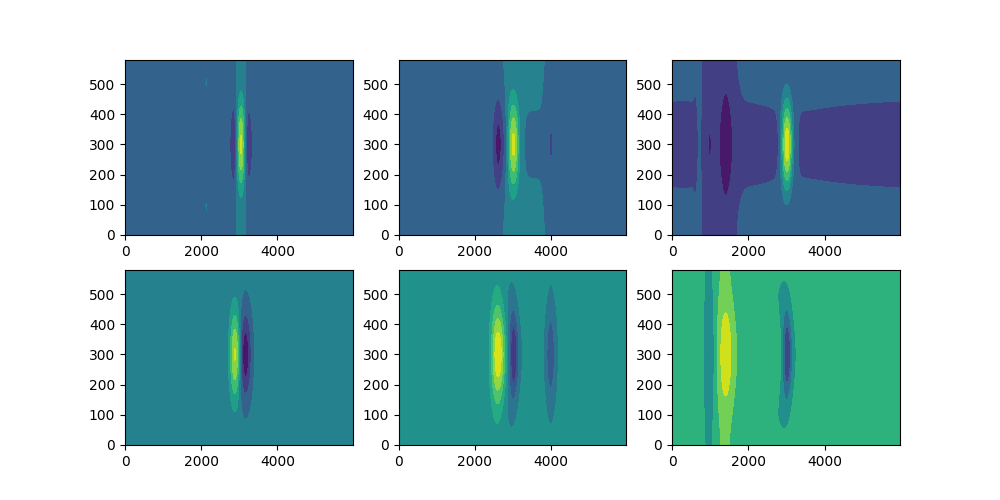

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(2, 3)
xpos=0
ypos=0

for time_step in range(1,int(n_timesteps)):
    time = time_step*Dt
    
    # Uncentered/forward time - Centered space
    # Here we assume that points are aranged as h_{j-1} - u_{j} - h_{j} - u_{j+1} etc.
    
    if Nonlinear=="True": # use non-linear advection terms
        u[:,:,time_step] = u[:,:,time_step-1] - (u[:,time_step-1]*Dt/(2*Dx))*(np.roll(u[:,:,time_step-1],-1,0) - \
                                                         np.roll(u[:,:,time_step-1],1,0)) \
                                      - (g*Dt/Dx)*(h[:,:,time_step-1] - \
                                                         np.roll(h[:,:,time_step-1],1,0))
        h[:,:,time_step] = h[:,:,time_step-1] - (u[:,:,time_step-1]*Dt/(2*Dx))*( (np.roll( (h[:,:,time_step-1]-h_s) ,-1,0) - \
                                                         np.roll( (h[:,:,time_step-1]-h_s) ,1,0)) \
                                      - ((h[:,:,time_step-1]-h_s)*Dt/Dx)*(np.roll(u[:,:,time_step-1],-1,0) - \
                                                         u[:,:,time_step-1]))
    else:
        u[:,:,time_step] = u[:,:,time_step-1] 
        u[:,:,time_step] += - (U*Dt/(2*Dx))*(np.roll(u[:,:,time_step-1],-1,0) - \
                                                         np.roll(u[:,:,time_step-1],1,0))
        u[:,:,time_step] += - (V*Dt/(2*Dy))*(np.roll(u[:,:,time_step-1],-1,1) - \
                                                         np.roll(u[:,:,time_step-1],1,1))
        u[:,:,time_step] += - (g*Dt/Dx)*(h[:,:,time_step-1] - \
                                                         np.roll(h[:,:,time_step-1],1,0))
        
        h[:,:,time_step] = h[:,:,time_step-1] 
        h[:,:,time_step] += - (U*Dt/(2*Dx))*( np.roll( (h[:,:,time_step-1]-h_s) ,-1,0) - \
                                                         np.roll( (h[:,:,time_step-1]-h_s) ,1,0))
        h[:,:,time_step] += - (V*Dt/(2*Dy))*( np.roll( (h[:,:,time_step-1]-h_s) ,-1,1) - \
                                                         np.roll( (h[:,:,time_step-1]-h_s) ,1,1))
        h[:,:,time_step] += - (H*Dt/Dx)*(np.roll(u[:,:,time_step-1],-1,0) - \
                                                         u[:,:,time_step-1])
        
        v[:,:,time_step] = v[:,:,time_step-1] 
        v[:,:,time_step] += - (U*Dt/(2*Dx))*(np.roll(v[:,:,time_step-1],-1,0) - \
                                                        np.roll(v[:,:,time_step-1],1,0))
        v[:,:,time_step] += - (V*Dt/(2*Dy))*(np.roll(v[:,:,time_step-1],-1,1) - \
                                                         np.roll(v[:,:,time_step-1],1,1))
        v[:,:,time_step] += - (g*Dt/Dy)*(h[:,:,time_step-1] - \
                                                         np.roll(h[:,:,time_step-1],1,1))
        
    if Diffusivity=="True": # Add diffusivity terms
        # x-derivatives
        u[:,:,time_step] += (K*Dt/(Dx**2))*(np.roll(u[:,:,time_step-1],-1,0) - 2*u[:,:,time_step-1] \
                                         + np.roll(u[:,:,time_step-1],1,0))
        v[:,:,time_step] += (K*Dt/(Dx**2))*(np.roll(v[:,:,time_step-1],-1,0) - 2*v[:,:,time_step-1] \
                                         + np.roll(v[:,:,time_step-1],1,0))
        h[:,:,time_step] += (K*Dt/(Dx**2))*(np.roll(h[:,:,time_step-1],-1,0) - 2*h[:,:,time_step-1] \
                                         + np.roll(h[:,:,time_step-1],1,0))
        # y-derivatives
        u[:,:,time_step] += (K*Dt/(Dy**2))*(np.roll(u[:,:,time_step-1],-1,1) - 2*u[:,:,time_step-1] \
                                         + np.roll(u[:,:,time_step-1],1,1))
        v[:,:,time_step] += (K*Dt/(Dy**2))*(np.roll(v[:,:,time_step-1],-1,1) - 2*v[:,:,time_step-1] \
                                         + np.roll(v[:,:,time_step-1],1,1))
        h[:,:,time_step] += (K*Dt/(Dy**2))*(np.roll(h[:,:,time_step-1],-1,1) - 2*h[:,:,time_step-1] \
                                         + np.roll(h[:,:,time_step-1],1,1))
        

    if (time==20) or (time==100) or (time==400):
        if plot_type=="Line":
            axs[ypos,xpos].plot(x, u[:,0,time_step],'k-',label="Numerical u at t={}".format(time))
            axs[ypos,xpos].plot(x, u[:,0,0],'k:',label="Initial u".format(time))
            ypos=ypos+1
            axs[ypos,xpos].plot(x, h[:,0,time_step],'k-',label="Numerical h at t={}".format(time))
            axs[ypos,xpos].plot(x, h[:,0,0],'k:',label="Initial h".format(time))
            xpos = xpos+1
            ypos=ypos-1
        elif plot_type=="Contour":
            axs[ypos,xpos].contourf(x, y, u[:,:,time_step])
            #axs[ypos,xpos].colorbar()
            ypos=ypos+1
            axs[ypos,xpos].contourf(x, y, h[:,:,time_step])
            xpos = xpos+1
            ypos=ypos-1
        
        
plt.show()

<IPython.core.display.Javascript object>


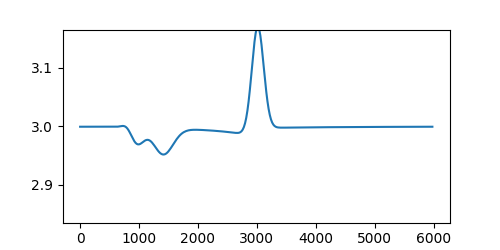

In [3]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()

line, = ax.plot(x[:,0], u[:,int(Ny/2),0])

def animate(i):
    line.set_ydata(u[:,int(Ny/2),i])  # update the data.
    return line,

ani = animation.FuncAnimation(
    fig, animate, frames=2000, interval=1, save_count=200)
plt.show()

<IPython.core.display.Javascript object>


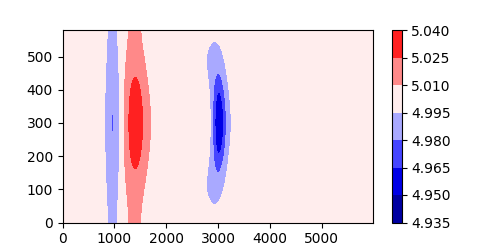

<function matplotlib.pyplot.show(block=None)>

In [4]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()
plt.contourf(x, y, h[:,:,-1], vmax=H+np.max(abs(h-H)), vmin=H-np.max(abs(h-H)), cmap='seismic')
            
plt.colorbar()
plt.show

<IPython.core.display.Javascript object>


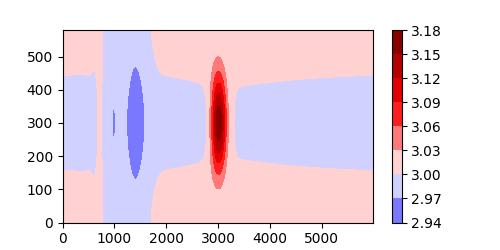

<function matplotlib.pyplot.show(block=None)>

In [5]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()
plt.contourf(x, y, u[:,:,-1], vmax=U+np.max(abs(u-U)), vmin=U-np.max(abs(u-U)), cmap='seismic')
            
plt.colorbar()
plt.show

<IPython.core.display.Javascript object>


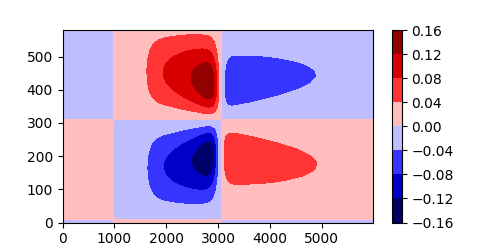

<function matplotlib.pyplot.show(block=None)>

In [6]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()
plt.contourf(x, y, v[:,:,-100], vmax=V+np.max(abs(v-V)), vmin=V-np.max(abs(v-V)), cmap='seismic')
            
plt.colorbar()
plt.show

In [7]:
x.shape, y.shape, u.shape, v.shape,u[:,:,-1].shape, y[0,:].shape

((300, 30), (300, 30), (300, 30, 801), (300, 30, 801), (300, 30), (30,))

<IPython.core.display.Javascript object>


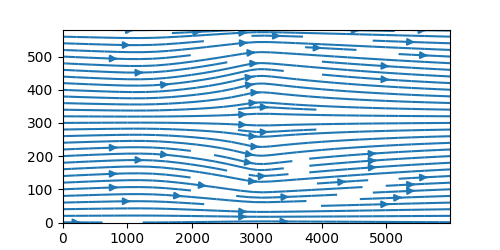

<function matplotlib.pyplot.show(block=None)>

In [8]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()
# plt.streamplot(y[0,:],x[:,0], v[:,:,-1], u[:,:,-1])
plt.streamplot(x[:,0],y[0,:], np.transpose(u[:,:,-1]), np.transpose(v[:,:,-1]))         
plt.show

<IPython.core.display.Javascript object>


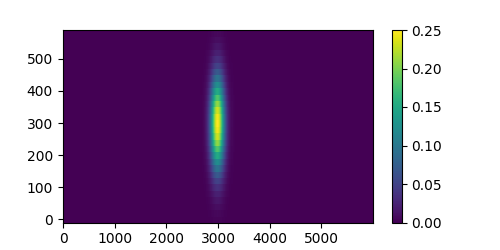

<function matplotlib.pyplot.show(block=None)>

In [9]:
plt.rcParams['figure.figsize'] = [5, 2.5]
fig, ax = plt.subplots()
plt.pcolor(x,y,h_s)
plt.colorbar()
plt.show

In [10]:
np.max(abs(u-U))

0.17098100841664898

In [11]:
x[:,0]

array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
        180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
        360.,  380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,
        540.,  560.,  580.,  600.,  620.,  640.,  660.,  680.,  700.,
        720.,  740.,  760.,  780.,  800.,  820.,  840.,  860.,  880.,
        900.,  920.,  940.,  960.,  980., 1000., 1020., 1040., 1060.,
       1080., 1100., 1120., 1140., 1160., 1180., 1200., 1220., 1240.,
       1260., 1280., 1300., 1320., 1340., 1360., 1380., 1400., 1420.,
       1440., 1460., 1480., 1500., 1520., 1540., 1560., 1580., 1600.,
       1620., 1640., 1660., 1680., 1700., 1720., 1740., 1760., 1780.,
       1800., 1820., 1840., 1860., 1880., 1900., 1920., 1940., 1960.,
       1980., 2000., 2020., 2040., 2060., 2080., 2100., 2120., 2140.,
       2160., 2180., 2200., 2220., 2240., 2260., 2280., 2300., 2320.,
       2340., 2360., 2380., 2400., 2420., 2440., 2460., 2480., 2500.,
       2520., 2540.,

In [12]:
y[0,:]

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
       220., 240., 260., 280., 300., 320., 340., 360., 380., 400., 420.,
       440., 460., 480., 500., 520., 540., 560., 580.])

In [13]:
Grid(x[:,0],y[0,:])

NameError: name 'Grid' is not defined